In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


import urllib.request
import os

# Download the dataset
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
filename = "course_lead_scoring.csv"

print(f"Downloading {filename}...")
# urllib.request.urlretrieve(url, filename)

# Verify the download
if os.path.exists(filename):
    file_size = os.path.getsize(filename)
    print(f"✅ Download successful!")
    print(f"File: {filename}")
    print(f"Size: {file_size} bytes")
else:
    print("❌ Download failed!")
#  desired target for classification task will be converted variable - has the client signed up to the platform or not.

✅ Download successful!
File: course_lead_scoring.csv
Size: 80876 bytes


In [3]:
df = pd.read_csv('course_lead_scoring.csv')
len(df)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
# Check if the missing values are presented in the features.
# If there are missing values:
# For caterogiral features, replace them with 'NA'
# For numerical features, replace with with 0.0
df.isnull().sum()[df.isnull().sum() > 0]

lead_source          128
industry             134
annual_income        181
employment_status    100
location              63
dtype: int64

In [6]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('NA')
    else:
        df[col] = df[col].fillna(0.0)
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [16]:
X = df.drop('converted', axis=1)
y = df['converted']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)
X_train.shape, X_val.shape, X_test.shape

((877, 8), (292, 8), (293, 8))

# Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
```
lead_score
number_of_courses_viewed
interaction_count
annual_income
```

Answer: number_of_courses_viewed

In [17]:
from sklearn.metrics import roc_auc_score

# Define the numerical variables to test
numerical_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Calculate AUC for each numerical variable
auc_scores = {}

for var in numerical_vars:
    # Use the variable as prediction score
    scores = X_train[var]
    
    # Calculate AUC
    auc = roc_auc_score(y_train, scores)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        scores_inverted = -X_train[var]
        auc_inverted = roc_auc_score(y_train, scores_inverted)
        auc_scores[var] = auc_inverted
        print(f"{var}: Original AUC = {auc:.4f}, Inverted AUC = {auc_inverted:.4f}")
    else:
        auc_scores[var] = auc
        print(f"{var}: AUC = {auc:.4f}")

# Find the variable with highest AUC
best_var = max(auc_scores, key=auc_scores.get)
print(f"\nHighest AUC: {best_var} with AUC = {auc_scores[best_var]:.4f}")

lead_score: AUC = 0.6111
number_of_courses_viewed: AUC = 0.7652
interaction_count: AUC = 0.7272
annual_income: AUC = 0.5446

Highest AUC: number_of_courses_viewed with AUC = 0.7652


# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)
```
0.32
0.52
0.72
0.92
```

Answer: closest 0.72

In [18]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

# Convert DataFrames to list of dictionaries for DictVectorizer
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# Apply one-hot encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

print(f"Training set shape after encoding: {X_train_encoded.shape}")
print(f"Validation set shape after encoding: {X_val_encoded.shape}")

# Train logistic regression with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Get probability predictions for AUC calculation
y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

# Calculate AUC on validation dataset
auc_score = roc_auc_score(y_val, y_val_pred_proba)
print(f"AUC on validation dataset: {round(auc_score, 3)}")

Training set shape after encoding: (877, 31)
Validation set shape after encoding: (292, 31)
AUC on validation dataset: 0.794


# Question 3 Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?
```
0.145
0.345
0.545
0.745
```

Answer: 0.6, closest from given list is 0.545

[0.34246575 0.34246575 0.34246575 0.34246575 0.34246575 0.34246575
 0.34246575 0.34246575 0.34246575 0.34246575 0.34246575 0.34246575
 0.34246575 0.34246575 0.34246575 0.34246575 0.34246575 0.34246575
 0.34246575 0.34246575 0.34020619 0.33617098 0.33617098 0.33617098
 0.33617098 0.33389201 0.33389201 0.33159722 0.32928644 0.32928644
 0.32225646 0.31820524 0.31582447 0.29959239 0.29710227 0.28897665
 0.27879105 0.26950188 0.26152567 0.25610632 0.25060328 0.23805147
 0.23231637 0.2252656  0.21639785 0.21036585 0.19692665 0.17998418
 0.17575918 0.15564123 0.15564123 0.14894924 0.12525691 0.11686934
 0.09780093 0.08626761 0.0707486  0.04202764 0.01258013 0.
 0.00844298 0.03842213 0.06912879 0.09852687 0.12004573 0.14794304
 0.15210324 0.18788451 0.18788451 0.20596264 0.2446396  0.2890625
 0.30561156 0.3208936  0.35714286 0.39270833 0.40826114 0.42463861
 0.46631944 0.4878876  0.54057018 0.61057692 0.64978448 0.66550926
 0.68399235 0.70684524 0.76736111 0.81149194 0.8275463  0.84821429
 0.9

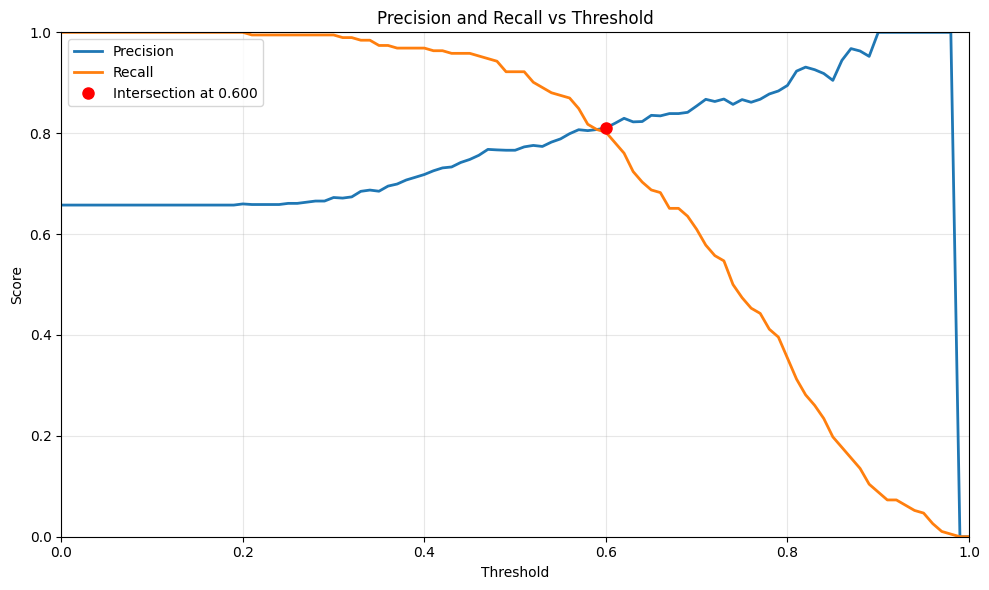


Answer: 0.600


In [20]:
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Get probability predictions (use the model from Question 2)
y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

# Calculate precision and recall for each threshold
precisions = []
recalls = []

for threshold in thresholds:
    # Convert probabilities to binary predictions using the threshold
    y_pred_threshold = (y_val_pred_proba >= threshold).astype(int)
    
    # Calculate precision and recall
    # Handle edge cases where no positive predictions are made
    if y_pred_threshold.sum() == 0:
        precision = 0.0 if threshold > 0 else np.nan
    else:
        precision = precision_score(y_val, y_pred_threshold, zero_division=0)
    
    recall = recall_score(y_val, y_pred_threshold, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)

# Convert to numpy arrays for easier manipulation
precisions = np.array(precisions)
recalls = np.array(recalls)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)

# Find intersection point
# Calculate absolute difference between precision and recall
diff = np.abs(precisions - recalls)

# Find the index where the difference is minimal (intersection)
# Exclude NaN values
valid_indices = ~(np.isnan(precisions) | np.isnan(recalls))
valid_diff = diff[valid_indices]
valid_thresholds = thresholds[valid_indices]
print(valid_diff)

if len(valid_diff) > 0:
    non_zero_mask = valid_diff > 0
    non_zero_diff = valid_diff[non_zero_mask]
    non_zero_thresholds = valid_thresholds[non_zero_mask]
    
    min_diff_idx = np.argmin(non_zero_diff)
    intersection_threshold = non_zero_thresholds[min_diff_idx]
    
    # Get the corresponding precision and recall values
    original_idx = np.where(valid_thresholds == intersection_threshold)[0][0]
    intersection_precision = precisions[valid_indices][original_idx]
    intersection_recall = recalls[valid_indices][original_idx]

    # Mark the intersection point
    plt.plot(intersection_threshold, intersection_precision, 'ro', markersize=8, label=f'Intersection at {intersection_threshold:.3f}')
    plt.legend()
    
    print(f"Precision and Recall curves intersect at threshold: {intersection_threshold:.3f}")
    print(f"Precision at intersection: {intersection_precision:.3f}")
    print(f"Recall at intersection: {intersection_recall:.3f}")

plt.tight_layout()
plt.show()

# Display the intersection threshold
print(f"\nAnswer: {intersection_threshold:.3f}")

# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1=2⋅P⋅R/ (P+R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?
```
0.14
0.34
0.54
0.74
```

Answer: 0.47, closest is 0.54

Maximum F1 score: 0.8485 at threshold: 0.470


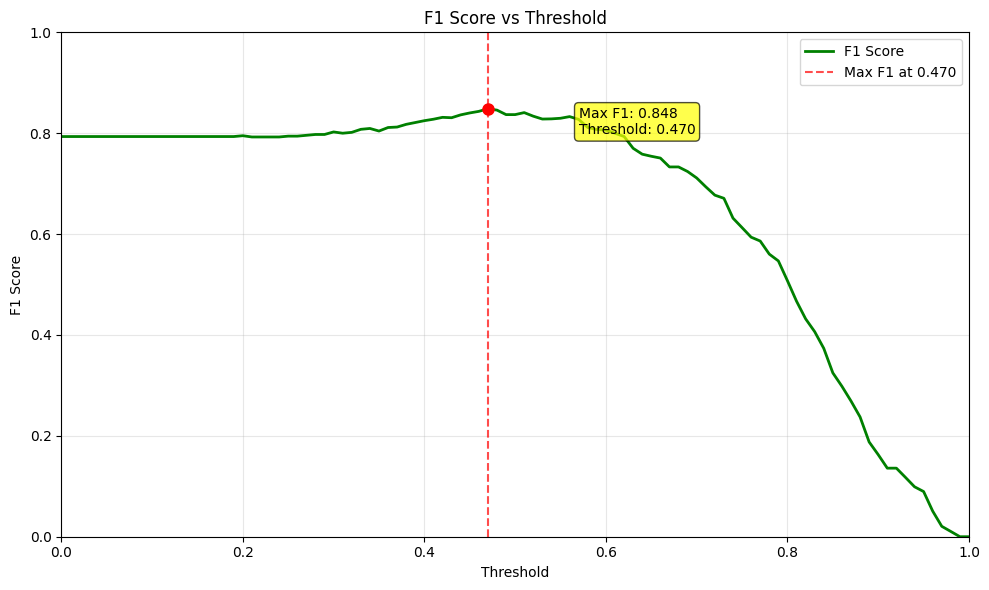


Answer: 0.47


In [21]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Get probability predictions (use the model from Question 2)
y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

# Calculate F1 score for each threshold
f1_scores = []

for threshold in thresholds:
    # Convert probabilities to binary predictions using the threshold
    y_pred_threshold = (y_val_pred_proba >= threshold).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_val, y_pred_threshold, zero_division=0)
    f1_scores.append(f1)

# Convert to numpy array
f1_scores = np.array(f1_scores)

# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_score:.4f} at threshold: {max_f1_threshold:.3f}")

# Plot F1 score vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='green')
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', alpha=0.7, label=f'Max F1 at {max_f1_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)

# Mark the maximum point
plt.plot(max_f1_threshold, max_f1_score, 'ro', markersize=8)
plt.annotate(f'Max F1: {max_f1_score:.3f}\nThreshold: {max_f1_threshold:.3f}', 
             xy=(max_f1_threshold, max_f1_score), 
             xytext=(max_f1_threshold + 0.1, max_f1_score - 0.05),
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\nAnswer: {max_f1_threshold:.2f}")

# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

```
0.0001
0.006
0.06
0.36
```

Answer: 0.022 - closest from given list is 0.06


In [22]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Combine train and validation sets to create df_full_train
# (excluding test set which we haven't used yet)
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

print(f"Full training set shape: {X_full_train.shape}")

# Initialize KFold with specified parameters
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores for each fold
auc_scores = []

# Iterate through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_train)):
    print(f"Processing fold {fold + 1}...")
    
    # Split data into train and validation for this fold
    X_fold_train = X_full_train.iloc[train_idx]
    X_fold_val = X_full_train.iloc[val_idx]
    y_fold_train = y_full_train.iloc[train_idx]
    y_fold_val = y_full_train.iloc[val_idx]
    
    # Convert to dictionaries for DictVectorizer
    train_dicts = X_fold_train.to_dict(orient='records')
    val_dicts = X_fold_val.to_dict(orient='records')
    
    # Apply one-hot encoding using DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_fold_train_encoded = dv.fit_transform(train_dicts)
    X_fold_val_encoded = dv.transform(val_dicts)
    
    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_fold_train_encoded, y_fold_train)
    
    # Get probability predictions for AUC calculation
    y_fold_val_pred_proba = model.predict_proba(X_fold_val_encoded)[:, 1]
    
    # Calculate AUC for this fold
    auc = roc_auc_score(y_fold_val, y_fold_val_pred_proba)
    auc_scores.append(auc)
    
    print(f"Fold {fold + 1} AUC: {auc:.4f}")

# Convert to numpy array for easier calculation
auc_scores = np.array(auc_scores)

# Calculate statistics
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"\nCross-Validation Results:")
print(f"AUC scores: {auc_scores}")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Standard Deviation: {std_auc:.4f}")

print(f"\nAnswer: {std_auc:.3f}")

Full training set shape: (1169, 8)
Processing fold 1...
Fold 1 AUC: 0.8067
Processing fold 2...
Fold 2 AUC: 0.8068
Processing fold 3...
Fold 3 AUC: 0.8648
Processing fold 4...
Fold 4 AUC: 0.8334
Processing fold 5...
Fold 5 AUC: 0.8154

Cross-Validation Results:
AUC scores: [0.80668039 0.80675018 0.86481935 0.83343809 0.81538462]
Mean AUC: 0.8254
Standard Deviation: 0.0220

Answer: 0.022


# Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?
```
0.000001
0.001
1
```
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.


Answer: 

In [23]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# C values to test
c_values = [0.000001, 0.001, 1]

# Use the same full training set from Question 5
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

# Initialize KFold with same parameters as previously
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results for each C value
results = {}

for C in c_values:
    print(f"\nTesting C = {C}")
    
    # Store AUC scores for each fold
    auc_scores = []
    
    # Iterate through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_train)):
        print(f"  Processing fold {fold + 1}...")
        
        # Split data into train and validation for this fold
        X_fold_train = X_full_train.iloc[train_idx]
        X_fold_val = X_full_train.iloc[val_idx]
        y_fold_train = y_full_train.iloc[train_idx]
        y_fold_val = y_full_train.iloc[val_idx]
        
        # Convert to dictionaries for DictVectorizer
        train_dicts = X_fold_train.to_dict(orient='records')
        val_dicts = X_fold_val.to_dict(orient='records')
        
        # Apply one-hot encoding using DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_fold_train_encoded = dv.fit_transform(train_dicts)
        X_fold_val_encoded = dv.transform(val_dicts)
        
        # Train logistic regression model with current C value
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_fold_train_encoded, y_fold_train)
        
        # Get probability predictions for AUC calculation
        y_fold_val_pred_proba = model.predict_proba(X_fold_val_encoded)[:, 1]
        
        # Calculate AUC for this fold
        auc = roc_auc_score(y_fold_val, y_fold_val_pred_proba)
        auc_scores.append(auc)
        
        print(f"    Fold {fold + 1} AUC: {auc:.4f}")
    
    # Convert to numpy array for easier calculation
    auc_scores = np.array(auc_scores)
    
    # Calculate statistics
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store results (rounded to 3 decimal digits)
    results[C] = {
        'mean': round(mean_auc, 3),
        'std': round(std_auc, 3),
        'scores': auc_scores
    }
    
    print(f"  Mean AUC: {results[C]['mean']}")
    print(f"  Std AUC: {results[C]['std']}")

# Display all results
print(f"\nSummary of Results:")
print("C\t\tMean\tStd")
print("-" * 25)
for C in c_values:
    print(f"{C}\t\t{results[C]['mean']}\t{results[C]['std']}")

# Find the best C according to the rules:
# 1. Highest mean score
# 2. If tied, lowest std
# 3. If still tied, smallest C

best_mean = max(results[C]['mean'] for C in c_values)
candidates_with_best_mean = [C for C in c_values if results[C]['mean'] == best_mean]

if len(candidates_with_best_mean) == 1:
    best_C = candidates_with_best_mean[0]
    print(f"\nBest C: {best_C} (highest mean score)")
else:
    print(f"\nTie in mean score ({best_mean}), checking std...")
    best_std = min(results[C]['std'] for C in candidates_with_best_mean)
    candidates_with_best_std = [C for C in candidates_with_best_mean if results[C]['std'] == best_std]
    
    if len(candidates_with_best_std) == 1:
        best_C = candidates_with_best_std[0]
        print(f"Best C: {best_C} (lowest std among tied means)")
    else:
        print(f"Still tied in std ({best_std}), selecting smallest C...")
        best_C = min(candidates_with_best_std)
        print(f"Best C: {best_C} (smallest C among tied)")

print(f"\nAnswer: {best_C}")


Testing C = 1e-06
  Processing fold 1...
    Fold 1 AUC: 0.5896
  Processing fold 2...
    Fold 2 AUC: 0.5160
  Processing fold 3...
    Fold 3 AUC: 0.5369
  Processing fold 4...
    Fold 4 AUC: 0.5308
  Processing fold 5...
    Fold 5 AUC: 0.5428
  Mean AUC: 0.543
  Std AUC: 0.025

Testing C = 0.001
  Processing fold 1...
    Fold 1 AUC: 0.8607
  Processing fold 2...
    Fold 2 AUC: 0.8402
  Processing fold 3...
    Fold 3 AUC: 0.8838
  Processing fold 4...
    Fold 4 AUC: 0.8712
  Processing fold 5...
    Fold 5 AUC: 0.8656
  Mean AUC: 0.864
  Std AUC: 0.014

Testing C = 1
  Processing fold 1...
    Fold 1 AUC: 0.8067
  Processing fold 2...
    Fold 2 AUC: 0.8068
  Processing fold 3...
    Fold 3 AUC: 0.8648
  Processing fold 4...
    Fold 4 AUC: 0.8334
  Processing fold 5...
    Fold 5 AUC: 0.8154
  Mean AUC: 0.825
  Std AUC: 0.022

Summary of Results:
C		Mean	Std
-------------------------
1e-06		0.543	0.025
0.001		0.864	0.014
1		0.825	0.022

Best C: 0.001 (highest mean score)

Ans